In [6]:
#imports
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [10]:
import re

#load previously saved artifacts
tfidf = joblib.load("../../../notebooks/artifacts/punctuation_no_stop_words/tfidf_vectorizer.joblib")
best_lr_l2 = joblib.load("../../../notebooks/artifacts/punctuation_no_stop_words/models/logreg_l2_best.joblib")
best_lr_l1 = joblib.load("../../../notebooks/artifacts/punctuation_no_stop_words/models/logreg_l1_best.joblib")
best_mlp   = joblib.load("../../../notebooks/artifacts/punctuation_no_stop_words/models/mlp_best.joblib")

#load data (same splits used earlier)
train_csv = "../data/train.csv"
val_csv   = "../data/val.csv"
test_csv  = "../data/test.csv"

val = pd.read_csv(val_csv)
train = pd.read_csv(train_csv)
test = pd.read_csv(test_csv)

# preprocess (same method applied earlier)
# cleaning the dataset - lowercases and removes extra whitespaces in every text
def clean_data(text):
    #check for actual missing values
    if pd.isna(text) or text is None:
        return None
        
    #convert to string and strip whitespace
    text_str = str(text).lower().strip()
    
    #check for literal string "None", "nan", or empty
    if text_str in ['none', 'nan', 'null', '']:
        return None
    
    return text_str

val['text_clean'] = val['Text'].apply(clean_data)
val = val.dropna(subset=['text_clean']).reset_index(drop=True)

X_val = tfidf.transform(val['text_clean'])
y_val = val['Label'].values
feature_names = tfidf.get_feature_names_out()

#target class names
class_names = ["Real", "Fake"]

c:\Users\danim\anaconda3\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.3.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\danim\anaconda3\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.3.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\danim\anaconda3\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.3.0 when using version 1.7.2. This might lead to b

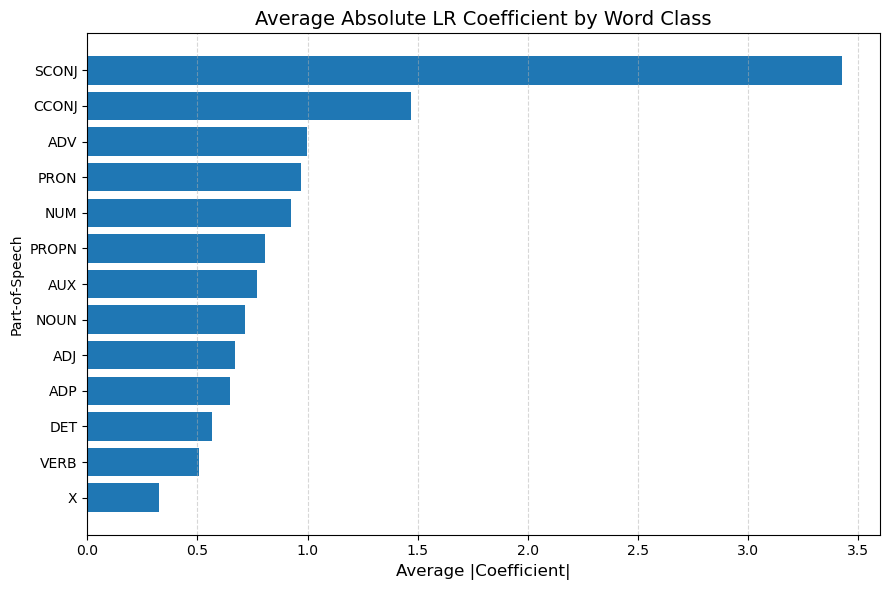

In [8]:
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load Portuguese large model
nlp = spacy.load("pt_core_news_lg")

# Get LR weights
weights = best_lr_l1.coef_[0]

# Build dataframe with POS + absolute weight
data = []
for word, w in zip(feature_names, weights):
    doc = nlp(word)
    if len(doc) == 0:
        continue
    pos = doc[0].pos_
    data.append({
        "pos": pos,
        "abs_weight": abs(w)
    })

df = pd.DataFrame(data)

# Compute average absolute weight per POS
pos_summary = (
    df.groupby("pos")["abs_weight"]
      .mean()
      .sort_values(ascending=True)
)

# Plot
plt.figure(figsize=(9, 6))
plt.barh(pos_summary.index, pos_summary.values)

plt.title("Average Absolute LR Coefficient by Word Class", fontsize=14)
plt.xlabel("Average |Coefficient|", fontsize=12)
plt.ylabel("Part-of-Speech")
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

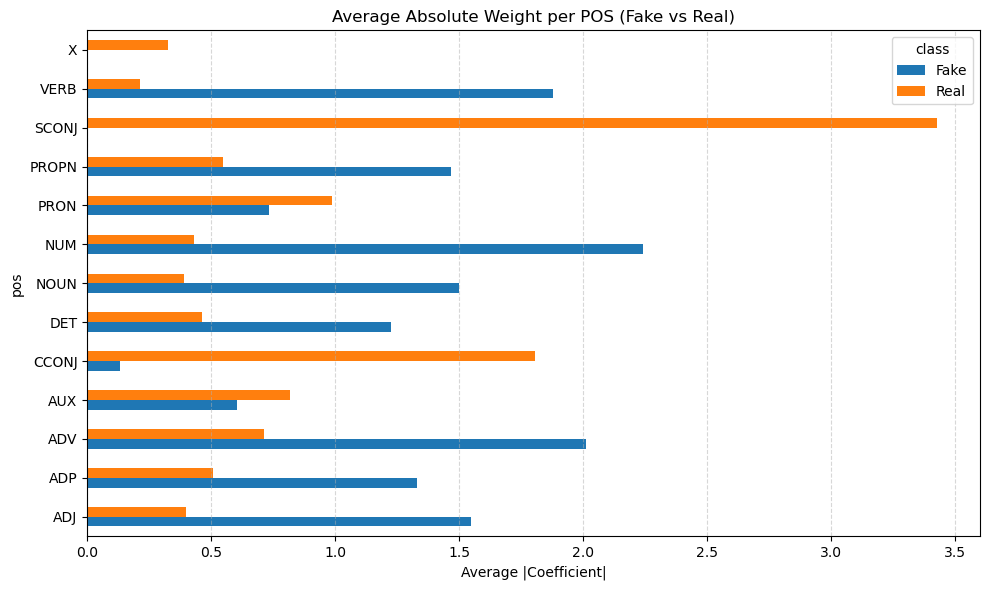

In [9]:
data = []

for word, w in zip(feature_names, weights):
    doc = nlp(word)
    if len(doc) == 0:
        continue
    pos = doc[0].pos_
    
    data.append({
        "pos": pos,
        "weight": w,
        "abs_weight": abs(w),
        "class": "Fake" if w > 0 else "Real"
    })

df_pos = pd.DataFrame(data)

# Mean positive and negative weight per POS
pos_class_summary = (
    df_pos.groupby(["pos", "class"])["abs_weight"]
    .mean()
    .unstack()
    .fillna(0)
)

pos_class_summary.plot(kind="barh", figsize=(10,6))
plt.title("Average Absolute Weight per POS (Fake vs Real)")
plt.xlabel("Average |Coefficient|")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Train class balance:
1    25378
0    25209
Name: Label, dtype: int64



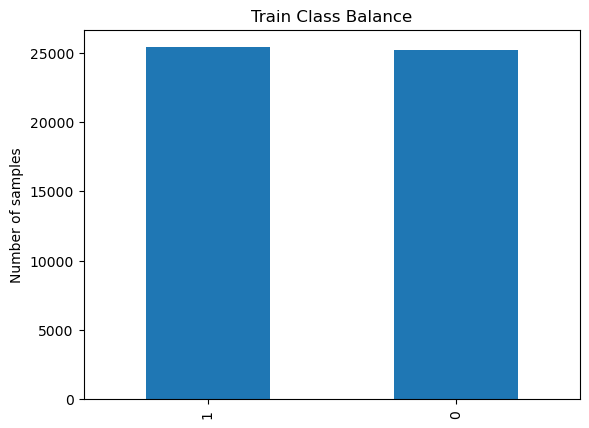

Validation class balance:
1    3180
0    3141
Name: Label, dtype: int64



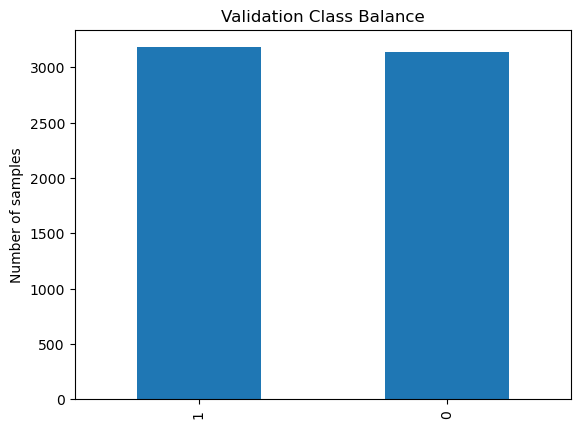

Test class balance:
0    3169
1    3155
Name: Label, dtype: int64



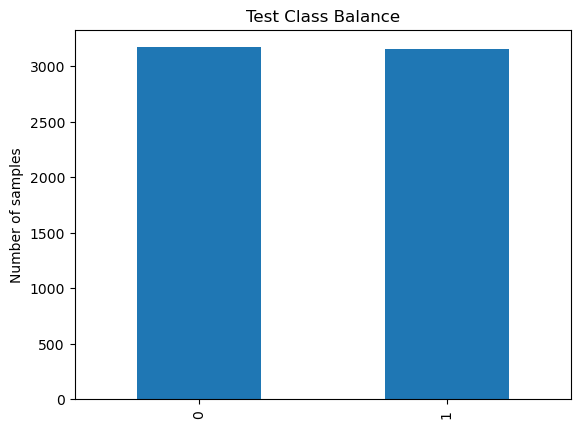

In [11]:
def check_balance(df, name="Dataset"):
    counts = df['Label'].value_counts()
    print(f"{name} class balance:\n{counts}\n")
    counts.plot(kind='bar', title=f"{name} Class Balance")
    plt.ylabel("Number of samples")
    plt.show()

check_balance(train, "Train")
check_balance(val, "Validation")
check_balance(test, "Test")

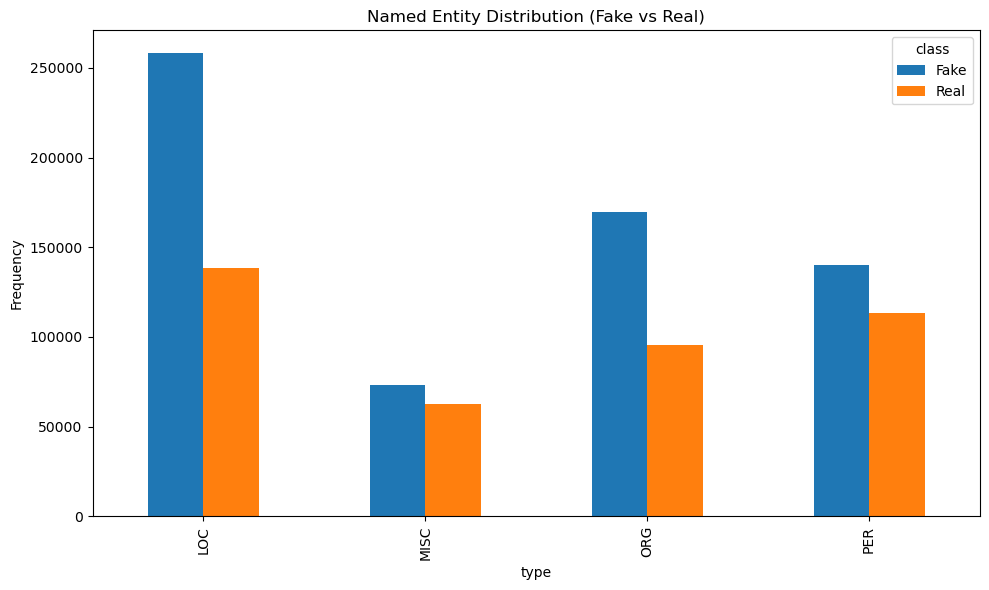

In [13]:
entity_data = []
texts = train['Text'].astype(str).tolist()
labels = train['Label'].values

for text, label in zip(texts, labels):
    doc = nlp(text)
    for ent in doc.ents:
        entity_data.append({
            "type": ent.label_,
            "class": "Fake" if label == 1 else "Real"
        })

df_ent = pd.DataFrame(entity_data)
if df_ent.empty:
    print(f"No entities found in Train")
else:
    entity_summary = (
        df_ent.groupby(["type", "class"])
        .size()
        .unstack()
        .fillna(0)
    )

    entity_summary.plot(kind="bar", figsize=(10,6))
    plt.title(f"Named Entity Distribution (Fake vs Real)")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

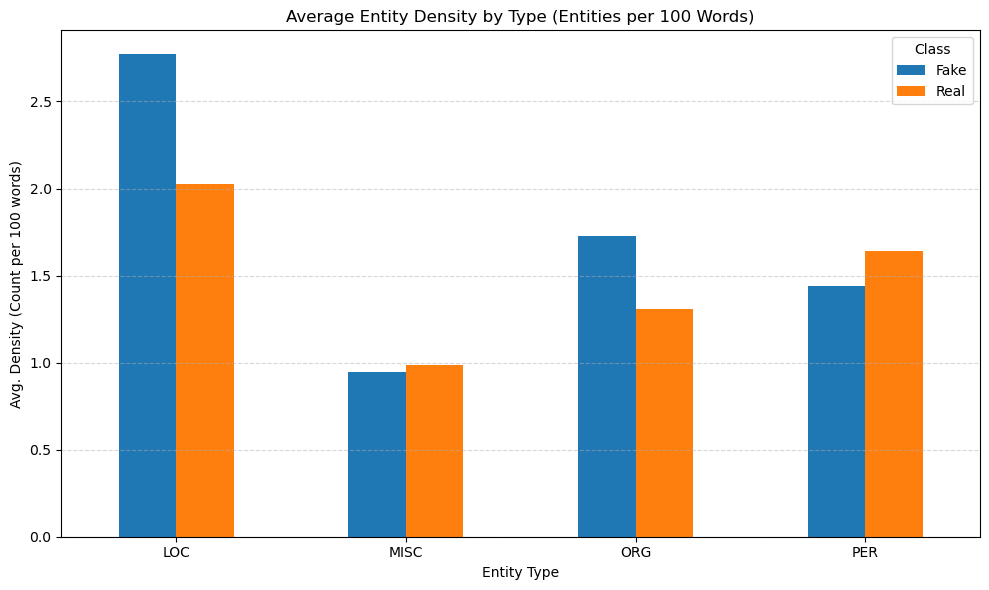

Average Density per 100 words by Type:
         LOC   MISC    ORG    PER
class                            
Fake   2.770  0.946  1.728  1.439
Real   2.024  0.987  1.306  1.640


In [18]:
# 1. Initialize data list for type-specific density
type_density_records = []

# Target types from your original graph
target_types = ["LOC", "MISC", "ORG", "PER"]

for text, label in zip(texts, labels):
    doc = nlp(text)
    word_count = len(text.split())
    
    # Skip empty texts to avoid division by zero
    if word_count == 0:
        continue
    
    # Initialize counts for this specific article
    counts = {t: 0 for t in target_types}
    for ent in doc.ents:
        if ent.label_ in counts:
            counts[ent.label_] += 1
            
    # Calculate density for each type: (Count / Words) * 100
    row = {"class": "Fake" if label == 1 else "Real"}
    for t in target_types:
        row[t] = (counts[t] / word_count) * 100
        
    type_density_records.append(row)

# 2. Create DataFrame and calculate averages
df_type_density = pd.DataFrame(type_density_records)
avg_type_density = df_type_density.groupby("class").mean()

# 3. Plotting (Transposing so Entity Type is on the X-axis)
# Note: 'avg_type_density.T' swaps rows and columns for the bar chart
avg_type_density.T.plot(kind="bar", figsize=(10, 6), color=['tab:blue', 'tab:orange'])

plt.title("Average Entity Density by Type (Entities per 100 Words)")
plt.ylabel("Avg. Density (Count per 100 words)")
plt.xlabel("Entity Type")
plt.xticks(rotation=0)
plt.legend(title="Class")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Print the table for exact numbers
print("Average Density per 100 words by Type:")
print(avg_type_density.round(3))

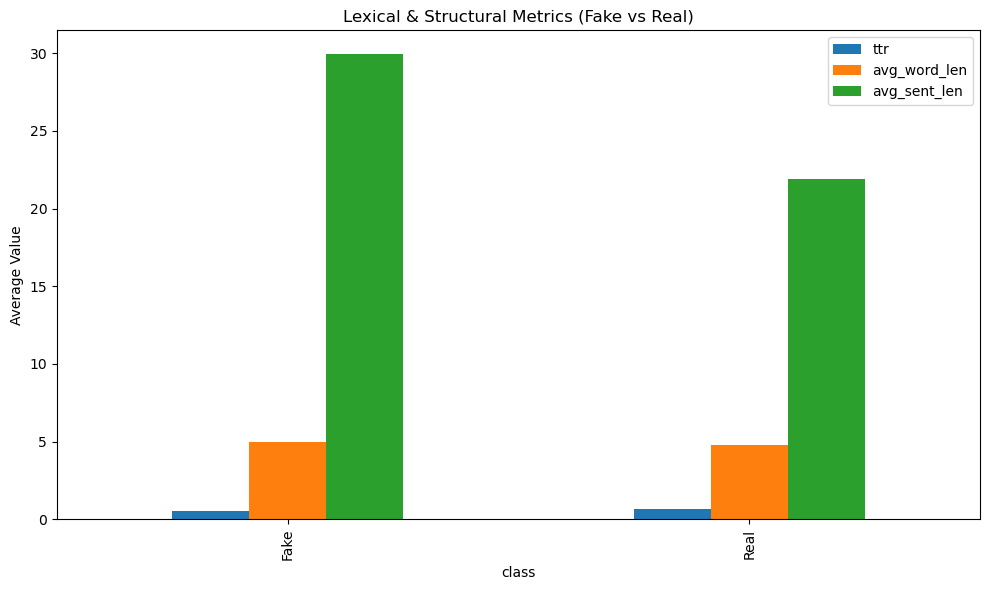

In [17]:
metrics = []
texts = train['Text'].astype(str).tolist()
labels = train['Label'].values

for text, label in zip(texts, labels):
    doc = nlp(text)
    tokens = [t.text for t in doc if t.is_alpha]
    if len(tokens) == 0:
        continue
    
    ttr = len(set(tokens)) / len(tokens)          # Type-Token Ratio
    avg_word_len = np.mean([len(t) for t in tokens])
    avg_sent_len = np.mean([len(sent) for sent in doc.sents])
    
    metrics.append({
        "class": "Fake" if label == 1 else "Real",
        "ttr": ttr,
        "avg_word_len": avg_word_len,
        "avg_sent_len": avg_sent_len
    })

df_metrics = pd.DataFrame(metrics)
summary_metrics = df_metrics.groupby("class").mean()

summary_metrics.plot(kind="bar", figsize=(10,6))
plt.title(f"Lexical & Structural Metrics (Fake vs Real)")
plt.ylabel("Average Value")
plt.tight_layout()
plt.show()

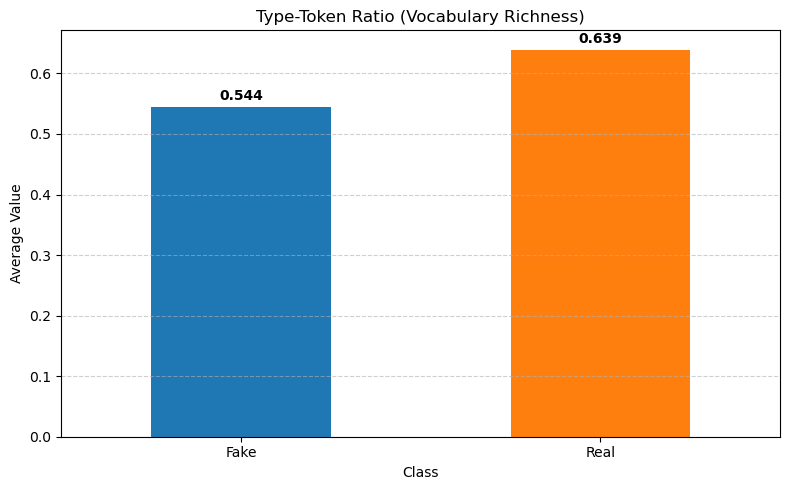

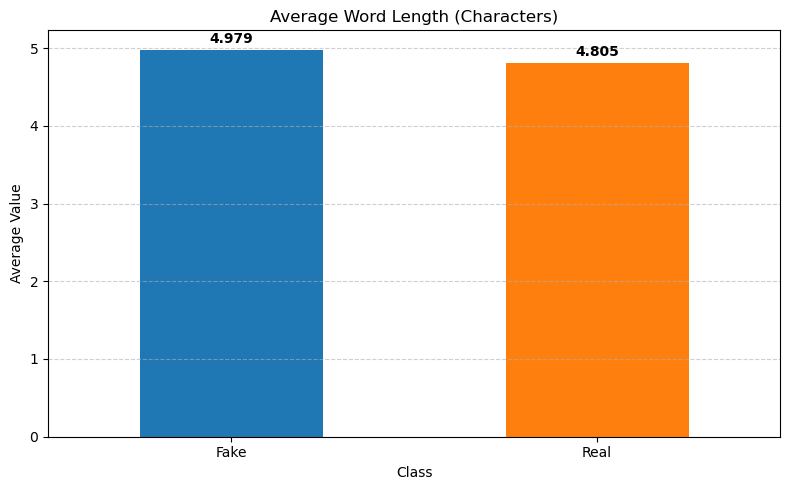

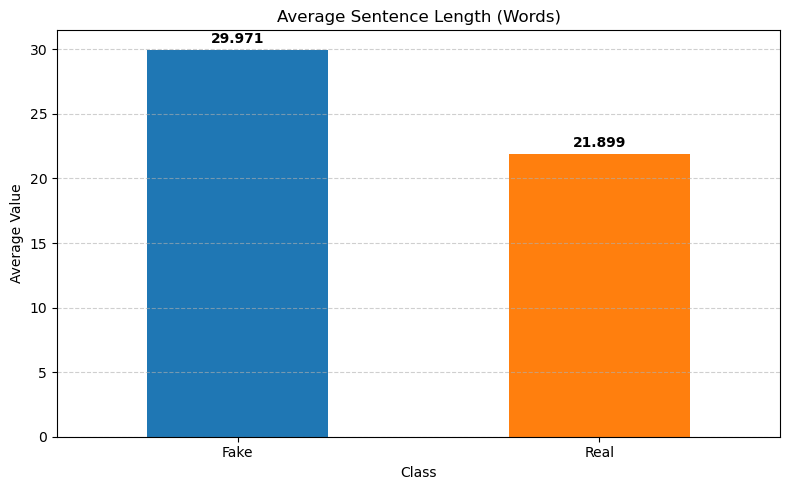

In [19]:
# List of metrics and readable titles for the graphs
metrics_list = ["ttr", "avg_word_len", "avg_sent_len"]
metric_titles = {
    "ttr": "Type-Token Ratio (Vocabulary Richness)",
    "avg_word_len": "Average Word Length (Characters)",
    "avg_sent_len": "Average Sentence Length (Words)"
}

# Loop through each metric and create a separate plot
for metric in metrics_list:
    plt.figure(figsize=(8, 5))
    
    # Calculate the mean for the current metric
    # We use df_metrics which was created in your previous block
    avg_data = df_metrics.groupby("class")[metric].mean()
    
    # Plot bar chart
    # Using specific colors to match your previous charts
    ax = avg_data.plot(kind="bar", color=['tab:blue', 'tab:orange'], rot=0)
    
    plt.title(f"{metric_titles[metric]}")
    plt.ylabel("Average Value")
    plt.xlabel("Class")
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    
    # Add the exact value numbers on top of the bars for clarity
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.3f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 8), 
                    textcoords='offset points',
                    fontsize=10, fontweight='bold')

    plt.tight_layout()
    plt.show()